# 🧠 Credit Decision Q-Learning System

This notebook implements a table-based **Q-Learning** system designed to optimize credit approval decisions. 

In [56]:
import numpy as np
from collections import defaultdict
import random

# HYPERPARAMETERS

ALPHA = 0.1        #Learing Rate
GAMMA = 0.9        #Discount Factor (How Feature is IMPORTANT)
EPSILON = 0.5      #Epsilon (ε): Exploration vs Exploitation
# Should I try something new? (explore)
# Or use what I already know? (exploit)

EPSILON_DECAY = 0.995 #This is a multiplier applied after each training episode.
MIN_EPSILON = 0.05  #Epsilon should never go below 0.05

NUM_ACTIONS = 4

In [57]:
# ACTION SPACE
ACTIONS = {
    0: "REJECT",
    1: "APPROVE_LOW",
    2: "APPROVE_MEDIUM",
    3: "APPROVE_HIGH"
}

In [58]:
# Q-TABLE
Q = defaultdict(lambda: np.zeros(NUM_ACTIONS))

#Initilize Q-Table With Four Entry (NUMBER OF ACTION)

### 📏 Probability of Default (PD) Discretization

The RL agent requires discrete 'Bins' to understand risk. We map the continuous PD score into 5 categories:

| PD Value Range | Category Index |
| :--- | :--- |
| < 0.2 | 0 |
| 0.2 – 0.4 | 1 |
| 0.4 – 0.6 | 2 |
| 0.6 – 0.8 | 3 |
| > 0.8 | 4 |

The graph below shows this mapping as a step function.

In [59]:
# DISCRETIZATION : Return val belong in which Category
def discretize(val, bins):
    return np.digitize(val, bins)

pd_bins = [0.2, 0.4, 0.6, 0.8]
# PD Value	    Category
# < 0.2	            0
# 0.2 – 0.4	        1
# 0.4 – 0.6	        2
# 0.6 – 0.8	        3
# > 0.8       	    4
anomaly_bins = [0.3, 0.6, 0.8]
emi_bins = [0.3, 0.5, 0.7]
balance_bins = [5000, 20000, 50000]
income_bins = [15000, 30000, 60000]

### 🧠 Q-Table State–Action Value Representation

In Q-Learning, every state–action pair maintains a learned value.

#### 🔹 Core Representation

```python
> Q[state][action]


In [60]:
# BUILD STATE (ML FEATURES FIRST)
def build_state(record):
    return (
        discretize(record["PD"], pd_bins),
        discretize(record["anomaly"], anomaly_bins),
        discretize(record["emiRatio"], emi_bins),
        discretize(record["avgBalance"], balance_bins),
        discretize(record["avgIncome"], income_bins)
    )
#Example 

# record = {
#     "PD": 0.35,
#     "anomaly": 0.15,
#     "emiRatio": 0.40,
#     "avgBalance": 35000,
#     "avgIncome": 55000
# }

# Return By function => Q-Table State : (1, 0, 1, 2, 2)

In [61]:
# EPSILON GREEDY ACTION
def choose_action(state, epsilon):
    if random.random() < epsilon: #Explore Case (Random action Do)
        return random.randint(0, NUM_ACTIONS-1)
    return np.argmax(Q[state])    #Exploitation Case (Already Done Action)

### Reward Function

- **Reject Decision**: If the customer has a high PD (>0.6), the agent gets a positive reward (+20) for being cautious. Otherwise, it gets a penalty (-20) for losing a potentially good customer.
- **Default Penalty**: If the agent approves a loan but the customer defaults, it receives a massive penalty (-200 minus a PD-based penalty) to discourage risky approvals.
- **Approval Rewards**: For successful (non-defaulting) approvals, the agent gets increasing rewards based on the limit given (High limit = +100).

In [62]:
#Reward Function (Give Reward According to PD Value)

# ✅ Did the customer pay back? (Reward)
# ❌ Did the customer default? (Penlty)

def calculate_reward(action, record):
    
    PD = record["PD"]
    defaulted = record["default"]

    if action == 0:  # Reject
        if PD > 0.6:
            return +20
        else:
            return -20
    #If Approve Loan Then default penlty According to PD

    #If PD is high then Approve have a High Risk So give more penlty
    if defaulted:
        return -200 - (PD * 100)

    if action == 1:  #APPROVE_LOW
        return 40

    if action == 2:  #APPROVE_MEDIUM
        return 70

    if action == 3:  #APPROVE_HIGH
        return 100

    return 0

In [63]:
# SAMPLE HISTORICAL DATA GENERATOR (SIMULATION)
def generate_fake_data(n=3000):
    data = []
    for _ in range(n):
        PD = np.random.rand()
        anomaly = np.random.rand()
        emi = np.random.rand()
        bal = np.random.randint(2000, 80000)
        inc = np.random.randint(10000, 100000)

        default = True if PD > 0.65 and random.random() < 0.7 else False

        data.append({
            "PD": PD,
            "anomaly": anomaly,
            "emiRatio": emi,
            "avgBalance": bal,
            "avgIncome": inc,
            "default": default
        })
    return data

## 🔁 Q-Learning Update Rule

```python
Q[state][action] = old_value + ALPHA * (reward + GAMMA * next_max - old_value)


In [64]:
# TRAINING
data = generate_fake_data()
epsilon = EPSILON
episodes=1000

for episode in range(episodes):

    random.shuffle(data)

    for record in data:
        #Convert Raw Data To Q table State
        state = build_state(record)
        #Choise Action
        action = choose_action(state, epsilon)
        #Give Reward
        reward = calculate_reward(action, record)

        next_state = state  # same customer snapshot

        old_value = Q[state][action]
        next_max = np.max(Q[next_state])# Best Reward For next_state 

        #Calculate 
        Q[state][action] = old_value + ALPHA * (
            reward + GAMMA * next_max - old_value
        )

    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}, epsilon={epsilon:.3f}")

Episode 100, epsilon=0.303
Episode 200, epsilon=0.183
Episode 300, epsilon=0.111
Episode 400, epsilon=0.067
Episode 500, epsilon=0.050
Episode 600, epsilon=0.050
Episode 700, epsilon=0.050
Episode 800, epsilon=0.050
Episode 900, epsilon=0.050
Episode 1000, epsilon=0.050


In [65]:
# TESTING FUNCTION
def recommend_action(record):
    state = build_state(record)
    #Which Action have a Max Reward For state That is our output
    action = np.argmax(Q[state])
    return ACTIONS[action]

# SAMPLE PREDICTION
sample_customer = {
    "PD": 0.01,
    "anomaly": 0.10,
    "emiRatio": 0.30,
    "avgBalance": 35000,
    "avgIncome": 55000,
    "default": False
}

print("\nRecommended Decision:",
      recommend_action(sample_customer))


Recommended Decision: APPROVE_HIGH


### 📊 Q-Table Snapshot (Heatmap Analysis)

This heatmap summarizes the 'intelligence' learned by the agent. It shows the **Average Q-Value** for each action across different **Probability of Default (PD)** categories.

- **Green areas** indicate high rewards (the agent prefers these decisions for that risk level).
- **Red areas** indicate high penalties (the agent avoids these decisions).

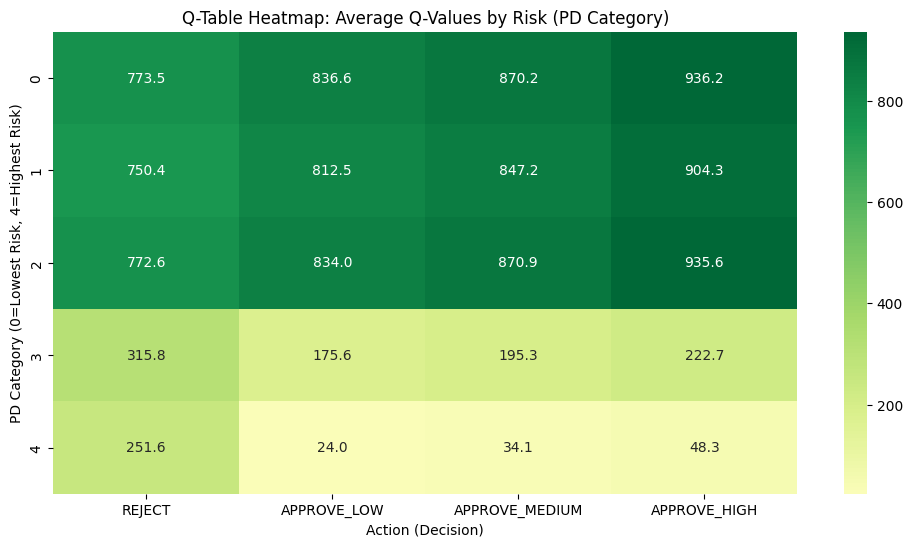

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================================
# Q-TABLE VISUALIZATION (SNAPSHOT)
# ==========================================================

def plot_q_table_snapshot(Q, ACTIONS):
    data = []
    for state, values in Q.items():
        pd_cat = state[0]
        for action_idx, q_val in enumerate(values):
            data.append({"PD_Category": pd_cat, "Action": ACTIONS[action_idx], "Q_Value": q_val})

    df = pd.DataFrame(data)
    if df.empty:
        print("Q-Table is empty. Please train the model first.")
        return
        
    pivot = df.pivot_table(index="PD_Category", columns="Action", values="Q_Value", aggfunc="mean")

    # Sort columns to maintain logical order
    action_order = ["REJECT", "APPROVE_LOW", "APPROVE_MEDIUM", "APPROVE_HIGH"]
    columns = [a for a in action_order if a in pivot.columns]
    pivot = pivot.reindex(columns=columns)

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="RdYlGn", center=0)
    plt.title("Q-Table Heatmap: Average Q-Values by Risk (PD Category)")
    plt.xlabel("Action (Decision)")
    plt.ylabel("PD Category (0=Lowest Risk, 4=Highest Risk)")
    plt.show()

plot_q_table_snapshot(Q, ACTIONS)